# Instalando os pacotes faltantes

In [ ]:
!apt install libspatialindex-dev
!pip install osmnx

# Baixando os dados

[Porto Taxi Service Trajectory](https://archive.ics.uci.edu/ml/datasets/Taxi+Service+Trajectory+-+Prediction+Challenge,+ECML+PKDD+2015)

In [1]:
!wget -O porto.zip 'https://archive.ics.uci.edu/ml/machine-learning-databases/00339/train.csv.zip'

--2020-03-18 18:33:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00339/train.csv.zip
Resolvendo archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Conectando-se a archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 533605607 (509M) [application/x-httpd-php]
Salvando em: “porto.zip”

porto.zip           100%[===================>] 508,89M  12,0MB/s    em 75s     

2020-03-18 18:34:50 (6,76 MB/s) - “porto.zip” salvo [533605607/533605607]



In [2]:
!unzip porto.zip

Archive:  porto.zip
  inflating: train.csv               


# Importando bibliotecas necessárias

* [Pandas](https://pandas.pydata.org/)
* [GeoPandas](https://geopandas.org/)
* [OSMNX](https://osmnx.readthedocs.io/en/stable/index.html)
* [tqdm](https://tqdm.github.io/)

In [3]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
from tqdm import tqdm

# Processamento dos dados

In [4]:
df = pd.read_csv('train.csv', nrows=1_000)

In [5]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [6]:
df[df['MISSING_DATA']]

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE


In [7]:
df['POLYLINE'][0]

'[[-8.618643,41.141412],[-8.618499,41.141376],[-8.620326,41.14251],[-8.622153,41.143815],[-8.623953,41.144373],[-8.62668,41.144778],[-8.627373,41.144697],[-8.630226,41.14521],[-8.632746,41.14692],[-8.631738,41.148225],[-8.629938,41.150385],[-8.62911,41.151213],[-8.629128,41.15124],[-8.628786,41.152203],[-8.628687,41.152374],[-8.628759,41.152518],[-8.630838,41.15268],[-8.632323,41.153022],[-8.631144,41.154489],[-8.630829,41.154507],[-8.630829,41.154516],[-8.630829,41.154498],[-8.630838,41.154489]]'

In [8]:
df[df['POLYLINE'] == '[]']

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
762,1372665673620000353,C,NaN,NaN,20000353,1372665673,A,False,[]


In [9]:
df = df[df['POLYLINE'] != '[]']

In [49]:
def get_trajectories_points(df):
    lon = []
    lat = []
    for p in df['POLYLINE'].values:
        coords = eval(p)
        for c in coords:
            lon.append(c[0])
            lat.append(c[1])
    return pd.DataFrame({'x': lon, 'y': lat})

In [50]:
data = get_trajectories_points(df)

In [51]:
data

,x,y
0,-8.618643,41.141412
1,-8.618499,41.141376
2,-8.620326,41.142510
3,-8.622153,41.143815
4,-8.623953,41.144373
...,...,...
47323,-8.582373,41.180526
47324,-8.581644,41.180094
47325,-8.581014,41.179257
47326,-8.580105,41.178789


# Grafo da rede de tráfego

In [52]:
def get_graph_from_place(place, nw, w):
    G = ox.graph_from_place(place, network_type=nw, which_result=w)
    N, E = ox.graph_to_gdfs(G, nodes=True, edges=True)
    return G, N, E

In [53]:
G, N, E = get_graph_from_place('Porto, Portugal', 'drive', 2)

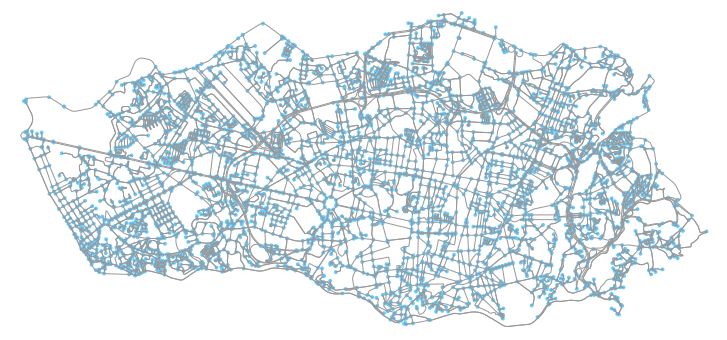

(<Figure size 1254.6x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fda944d2f90>)

In [54]:
ox.plot_graph(G)

In [55]:
N.head()

,y,x,osmid,highway,ref,geometry
1788788736,41.168155,-8.655250,1788788736,NaN,NaN,POINT (-8.65525 41.16816)
435240964,41.176506,-8.613195,435240964,NaN,NaN,POINT (-8.61319 41.17651)
296058885,41.179409,-8.629583,296058885,NaN,NaN,POINT (-8.62958 41.17941)
435240969,41.174896,-8.611751,435240969,NaN,NaN,POINT (-8.61175 41.17490)
435240970,41.175156,-8.611726,435240970,NaN,NaN,POINT (-8.61173 41.17516)


In [56]:
E.head()

,u,v,key,osmid,highway,oneway,length,geometry,name,lanes,ref,maxspeed,access,width,tunnel,bridge,junction,area,service
0,1788788736,501173321,0,41096616,living_street,False,23.579,"LINESTRING (-8.65525 41.16816, -8.65506 41.16800)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1788788736,4468615942,0,41096616,living_street,False,32.932,"LINESTRING (-8.65525 41.16816, -8.65547 41.168...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1788788736,4734724174,0,449940695,living_street,False,48.640,"LINESTRING (-8.65525 41.16816, -8.65520 41.168...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,435240964,432597949,0,37338734,tertiary,True,112.364,"LINESTRING (-8.61319 41.17651, -8.61240 41.176...",Rua Doutor Carlos Ramos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,435240964,4526609649,0,37338735,residential,False,250.745,"LINESTRING (-8.61319 41.17651, -8.61283 41.175...",Rua Sá de Miranda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
E['indexing'] = E.index
E['density'] = 1
E.drop(
    labels=['lanes', 'ref', 'maxspeed', 'access', 'width', 
            'tunnel', 'bridge', 'junction', 'area', 'service'], 
    axis=1, inplace=True
)

In [58]:
E.head()

,u,v,key,osmid,highway,oneway,length,geometry,name,indexing,density
0,1788788736,501173321,0,41096616,living_street,False,23.579,"LINESTRING (-8.65525 41.16816, -8.65506 41.16800)",NaN,0,1
1,1788788736,4468615942,0,41096616,living_street,False,32.932,"LINESTRING (-8.65525 41.16816, -8.65547 41.168...",NaN,1,1
2,1788788736,4734724174,0,449940695,living_street,False,48.640,"LINESTRING (-8.65525 41.16816, -8.65520 41.168...",NaN,2,1
3,435240964,432597949,0,37338734,tertiary,True,112.364,"LINESTRING (-8.61319 41.17651, -8.61240 41.176...",Rua Doutor Carlos Ramos,3,1
4,435240964,4526609649,0,37338735,residential,False,250.745,"LINESTRING (-8.61319 41.17651, -8.61283 41.175...",Rua Sá de Miranda,4,1


In [59]:
N.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5257 entries, 1788788736 to 435240959
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   y         5257 non-null   float64 
 1   x         5257 non-null   float64 
 2   osmid     5257 non-null   int64   
 3   highway   251 non-null    object  
 4   ref       11 non-null     object  
 5   geometry  5257 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 287.5+ KB


In [60]:
E.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11335 entries, 0 to 11334
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   u         11335 non-null  int64   
 1   v         11335 non-null  int64   
 2   key       11335 non-null  int64   
 3   osmid     11335 non-null  object  
 4   highway   11335 non-null  object  
 5   oneway    11335 non-null  bool    
 6   length    11335 non-null  float64 
 7   geometry  11335 non-null  geometry
 8   name      10041 non-null  object  
 9   indexing  11335 non-null  int64   
 10  density   11335 non-null  int64   
dtypes: bool(1), float64(1), geometry(1), int64(5), object(3)
memory usage: 896.7+ KB


In [61]:
N.shape, E.shape

((5257, 6), (11335, 11))

# [Map matching](https://www.wikiwand.com/en/Map_matching)

In [62]:
def get_nearest_edges_from_dataframe(df):
    nearest_edges = ox.geo_utils.get_nearest_edges(
        G, 
        df['x'].values, df['y'].values, 
        method='balltree'
    )
    return nearest_edges

In [63]:
nearest_edges = get_nearest_edges_from_dataframe(data)

In [64]:
nearest_edges, len(nearest_edges)

(array([[ 286969943,  122549700],
        [ 286969943,  122549700],
        [ 122549700,  286969943],
        ...,
        [ 444030215, 1838445656],
        [ 444030221,  444030215],
        [ 444030221, 5286385840]]),
 47328)

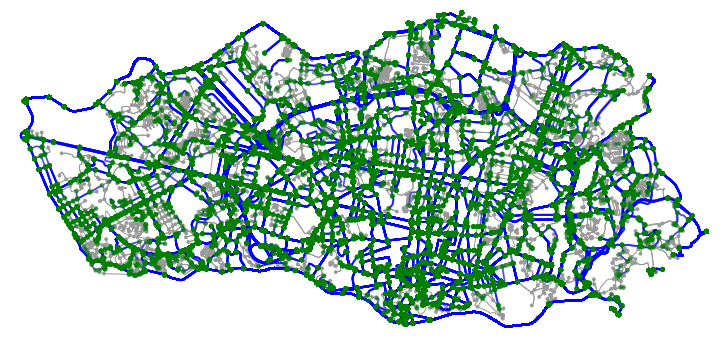

(<Figure size 1254.6x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fda9301d550>)

In [65]:
ox.plot_graph_routes(G, nearest_edges, route_linewidth=2, route_color='blue',
                     orig_dest_node_size=25, orig_dest_node_color='green')

In [66]:
def get_new_edges(nearest_edges):
    edges = []
    for u, v in tqdm(nearest_edges):
        edges.append(E[(E['u'] == u) & (E['v'] == v)].sort_values(by='length').values[0])
    new_E = gpd.GeoDataFrame(edges, columns=E.columns)
    return new_E

In [67]:
new_E = get_new_edges(nearest_edges)

100%|██████████| 47328/47328 [02:21<00:00, 333.99it/s]


In [68]:
new_E.head()

,u,v,key,osmid,highway,oneway,length,geometry,name,indexing,density
0,286969943,122549700,0,96151239,primary,False,643.600,"LINESTRING (-8.61743 41.14092, -8.61826 41.141...",Rua Nova da Alfândega,2940,1
1,286969943,122549700,0,96151239,primary,False,643.600,"LINESTRING (-8.61743 41.14092, -8.61826 41.141...",Rua Nova da Alfândega,2940,1
2,122549700,286969943,0,96151239,primary,False,643.600,"LINESTRING (-8.62357 41.14426, -8.62316 41.144...",Rua Nova da Alfândega,9508,1
3,286969943,122549700,0,96151239,primary,False,643.600,"LINESTRING (-8.61743 41.14092, -8.61826 41.141...",Rua Nova da Alfândega,2940,1
4,122549700,111467467,0,28193999,primary,False,277.504,"LINESTRING (-8.62357 41.14426, -8.62432 41.144...",Rua de Monchique,9506,1


In [69]:
new_E.shape

(47328, 11)

# Dense paths

In [70]:
new_E_dropped = new_E.drop_duplicates(['indexing']).copy()

In [71]:
new_E_dropped.shape

(4358, 11)

In [72]:
new_E_dense = new_E.groupby('indexing').sum()

In [73]:
new_E_dense

,u,v,key,oneway,length,density
indexing,,,,,,
3,1305722892,1297793847,0,3.0,337.092,3
5,2960588850,16287532890,0,0.0,1553.780,10
6,6513295470,34355662990,0,22.0,1492.436,22
14,8532672638,3005669877,0,0.0,2456.958,7
15,6094766170,6321396625,0,0.0,145.840,5
...,...,...,...,...,...,...
11328,17247436568,6630837472,0,0.0,26153.534,58
11330,297369597,1556432407,0,1.0,52.781,1
11331,594739194,7437534914,0,2.0,381.320,2


In [74]:
new_E_dropped.head()

,u,v,key,osmid,highway,oneway,length,geometry,name,indexing,density
0,286969943,122549700,0,96151239,primary,False,643.600,"LINESTRING (-8.61743 41.14092, -8.61826 41.141...",Rua Nova da Alfândega,2940,1
2,122549700,286969943,0,96151239,primary,False,643.600,"LINESTRING (-8.62357 41.14426, -8.62316 41.144...",Rua Nova da Alfândega,9508,1
4,122549700,111467467,0,28193999,primary,False,277.504,"LINESTRING (-8.62357 41.14426, -8.62432 41.144...",Rua de Monchique,9506,1
5,111467467,122549700,0,28193999,primary,False,277.504,"LINESTRING (-8.62676 41.14476, -8.62668 41.144...",Rua de Monchique,4543,1
6,478821940,111467467,0,"[759298060, 12298717, 28193999]",primary,False,447.704,"LINESTRING (-8.63145 41.14614, -8.63079 41.145...","[Alameda de Basilio Teles, Viaduto do Cais das...",10926,1


In [75]:
new_E_dropped['density'] = new_E_dropped['indexing'].apply(lambda x: new_E_dense.loc[x]['density'])

In [76]:
new_E_dropped.head()

,u,v,key,osmid,highway,oneway,length,geometry,name,indexing,density
0,286969943,122549700,0,96151239,primary,False,643.600,"LINESTRING (-8.61743 41.14092, -8.61826 41.141...",Rua Nova da Alfândega,2940,67.0
2,122549700,286969943,0,96151239,primary,False,643.600,"LINESTRING (-8.62357 41.14426, -8.62316 41.144...",Rua Nova da Alfândega,9508,106.0
4,122549700,111467467,0,28193999,primary,False,277.504,"LINESTRING (-8.62357 41.14426, -8.62432 41.144...",Rua de Monchique,9506,19.0
5,111467467,122549700,0,28193999,primary,False,277.504,"LINESTRING (-8.62676 41.14476, -8.62668 41.144...",Rua de Monchique,4543,21.0
6,478821940,111467467,0,"[759298060, 12298717, 28193999]",primary,False,447.704,"LINESTRING (-8.63145 41.14614, -8.63079 41.145...","[Alameda de Basilio Teles, Viaduto do Cais das...",10926,141.0


In [77]:
new_E_dropped.shape, new_E_dropped[new_E_dropped['density'] >= 50].shape

((4358, 11), (139, 11))

In [78]:
def get_dense_paths(new_E, thresh):
    new_E_dropped = new_E.drop_duplicates(['indexing']).copy()
    new_E_dense = new_E.groupby('indexing').sum()
    new_E_dropped['density'] = new_E_dropped['indexing'].apply(lambda x: new_E_dense.loc[x]['density'])
    new_E_dropped = new_E_dropped[new_E_dropped['density'] >= thresh]
    return new_E_dropped

In [79]:
new_E_dense = get_dense_paths(new_E, 50)

In [80]:
def save_new_graph(new_E):
    new_G = ox.gdfs_to_graph(N, new_E)
    return new_G

In [81]:
dense_G = save_new_graph(new_E_dense)

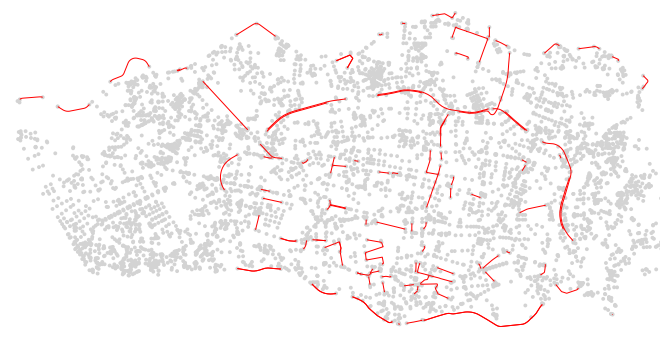

(<Figure size 1149.27x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fda912ab910>)

In [82]:
ox.plot_graph(dense_G, edge_color='red', node_color='lightgray')

# Mapa interativo

In [83]:
routes_G = save_new_graph(new_E)

In [84]:
m = ox.plot_graph_folium(routes_G, edge_color='gray', edge_width=1)

In [85]:
dm = ox.plot_graph_folium(dense_G, m, popup_attribute='density',
                          edge_width=5, edge_color='red')

In [86]:
dm.save('porto_taxi_dense_paths_map.html')